In [1]:
from experiment_running import *
import multiprocessing
multiprocessing.set_start_method("spawn")

# Limit number of threading
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMBA_NUM_THREADS"] = "1"
torch.set_num_threads(1)

# Plotting functions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

from sql_classes import ExperimentResult, ExperimentMetrics, Base

def load_data(db_path="sqlite:///experiments.db"):
    engine = create_engine(db_path)
    Session = sessionmaker(bind=engine)
    session = Session()

    # Query to join ExperimentResult and ExperimentMetrics
    query = session.query(
        ExperimentResult.learning_rate,
        ExperimentMetrics.epoch,
        ExperimentMetrics.train_loss,
        ExperimentMetrics.test_loss,
        ExperimentMetrics.train_acc,
        ExperimentMetrics.test_acc
    ).join(ExperimentMetrics, ExperimentResult.id == ExperimentMetrics.experiment_id)

    # Convert to DataFrame
    df = pd.read_sql(query.statement, session.bind)

    session.close()
    return df

def compute_statistics(df):
    """
    Group the data by learning_rate and epoch, then compute mean and standard error.
    """
    grouped = df.groupby(['learning_rate', 'epoch'])

    stats = grouped.agg(
        mean_train_loss=('train_loss', 'mean'),
        sem_train_loss=('train_loss', 'sem'),
        mean_test_loss=('test_loss', 'mean'),
        sem_test_loss=('test_loss', 'sem'),
        mean_train_acc=('train_acc', 'mean'),
        sem_train_acc=('train_acc', 'sem'),
        mean_test_acc=('test_acc', 'mean'),
        sem_test_acc=('test_acc', 'sem'),
    ).reset_index()

    return stats

def plot_metrics(stats):
    """
    Create two plots:
    1. Average Training and Testing Losses vs. Epochs with Error Bars.
    2. Average Training and Testing Accuracies vs. Epochs with Error Bars.
    """
    learning_rates = sorted(stats['learning_rate'].unique())
    epochs = sorted(stats['epoch'].unique())

    # Define a color map
    cmap = plt.get_cmap('tab10')
    colors = {lr: cmap(i % 10) for i, lr in enumerate(learning_rates)}

    _, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(10, 4))
    capsize=5
    markersize=4
    # --- Plot 1: Loss ---
    for lr in learning_rates:
        lr_data = stats[stats['learning_rate'] == lr].sort_values('epoch')
        ax_1.errorbar(
            lr_data['epoch'],
            lr_data['mean_train_loss'],
            yerr=lr_data['sem_train_loss'],
            color=colors[lr],
            linestyle='-',
            marker='o',
            label=f'LR={lr:.3f} Train',
            capsize=capsize,
            markersize = markersize
        )
        ax_1.errorbar(
            lr_data['epoch'],
            lr_data['mean_test_loss'],
            yerr=lr_data['sem_test_loss'],
            color=colors[lr],
            linestyle='--',
            marker='^',
            label=f'LR={lr:.3f} Test',
            capsize=capsize,
            markersize = markersize
        )

    ax_1.set_xlabel('Epoch')
    ax_1.set_ylabel('Loss')
    ax_1.set_title('Average Training and Testing Loss vs. Epochs')
    ax_1.set_yscale('log')
    ax_1.legend()
    ax_1.grid(True, which="both", linestyle='--', linewidth=0.5)

    # --- Plot 2: Accuracy ---
    for lr in learning_rates:
        lr_data = stats[stats['learning_rate'] == lr].sort_values('epoch')
        ax_2.errorbar(
            lr_data['epoch'],
            lr_data['mean_train_acc'],
            yerr=lr_data['sem_train_acc'],
            color=colors[lr],
            linestyle='-',
            marker='o',
            label=f'LR={lr:.3f} Train',
            capsize=capsize,
            markersize = markersize
        )
        ax_2.errorbar(
            lr_data['epoch'],
            lr_data['mean_test_acc'],
            yerr=lr_data['sem_test_acc'],
            color=colors[lr],
            linestyle='--',
            marker='^',
            label=f'LR={lr:.3f} Test',
            capsize=capsize,
            markersize = markersize
        )

    ax_2.set_xlabel('Epoch')
    ax_2.set_ylabel('Accuracy')
    ax_2.set_title('Average Training and Testing Accuracy vs. Epochs')
    ax_2.set_yscale('log')
    ax_2.legend()
    ax_2.grid(True, which="both", linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

# Running experiment

In [3]:
def parallel_experiments(
    learning_rates,
    n_trajectories,
    target_epochs,
    db_path="sqlite:///experiments.db",
    num_processes=2
):
    # Create the database tables **once** in the main process
    engine = create_engine(db_path)
    Base.metadata.create_all(engine)

    tasks = []
    for lr in learning_rates:
        for ind_traj in range(n_trajectories):
            tasks.append((
                lr, target_epochs, ind_traj,
                32, 16, db_path
            ))

    if num_processes > 1:
        with multiprocessing.Pool(processes=num_processes) as pool:
            pool.map(worker, tasks)
    else:
        # Run sequentially for debugging
        for t in tasks:
            worker(t)

## Run 1

In [4]:
learning_rates = [0.001, 0.01, 0.1]
n_trajectories = 10
target_epochs = 10
num_processes = 6
db_path = "sqlite:///experiments.db"

parallel_experiments(
    learning_rates,
    n_trajectories,
    target_epochs,
    db_path=db_path,
    num_processes=num_processes  # Adjust based on your CPU cores
)

Starting new experiment: LR=0.01, Trajectory=0
[LR=0.01, Trajectory=0, Epoch=1/10] Train Loss: 0.4789, Train Acc: 0.7612, Test Loss: 0.3217, Test Acc: 0.8450
[LR=0.01, Trajectory=0, Epoch=2/10] Train Loss: 0.2958, Train Acc: 0.8750, Test Loss: 0.2808, Test Acc: 0.8600
[LR=0.01, Trajectory=0, Epoch=3/10] Train Loss: 0.2741, Train Acc: 0.8750, Test Loss: 0.2714, Test Acc: 0.8650
[LR=0.01, Trajectory=0, Epoch=4/10] Train Loss: 0.2636, Train Acc: 0.8862, Test Loss: 0.2591, Test Acc: 0.8750
[LR=0.01, Trajectory=0, Epoch=5/10] Train Loss: 0.2496, Train Acc: 0.8938, Test Loss: 0.2427, Test Acc: 0.8800
[LR=0.01, Trajectory=0, Epoch=6/10] Train Loss: 0.2337, Train Acc: 0.9125, Test Loss: 0.2209, Test Acc: 0.9050
[LR=0.01, Trajectory=0, Epoch=7/10] Train Loss: 0.2123, Train Acc: 0.9263, Test Loss: 0.1939, Test Acc: 0.9150
[LR=0.01, Trajectory=0, Epoch=8/10] Train Loss: 0.1932, Train Acc: 0.9363, Test Loss: 0.1733, Test Acc: 0.9350
[LR=0.01, Trajectory=0, Epoch=9/10] Train Loss: 0.1701, Train Acc

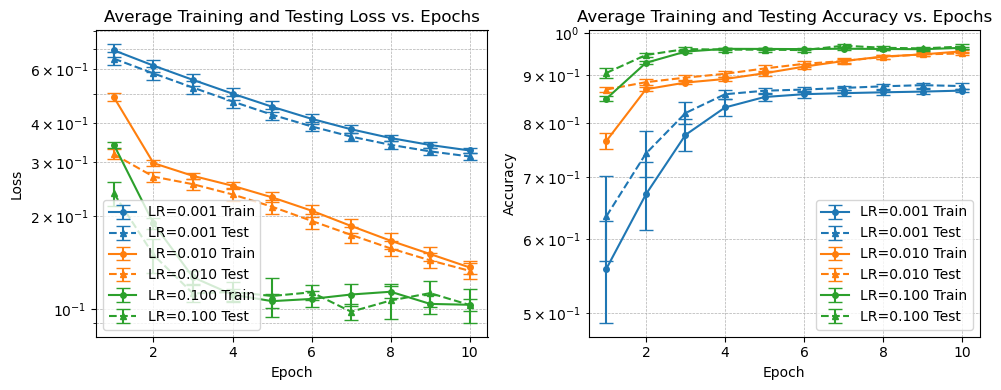

In [5]:
df = load_data("sqlite:///experiments.db")

if df.empty:
    print("No data found in the database.")

stats = compute_statistics(df)
plot_metrics(stats)

### DB structure

In [11]:
from sqlalchemy import create_engine, inspect

# Replace with your database URL
db_path = "sqlite:///experiments.db"

# Create an engine and inspector
engine = create_engine(db_path)
inspector = inspect(engine)

# Get all tables in the database
tables = inspector.get_table_names()

print("Database Structure:")
for table_name in tables:
    print(f"\nTable: {table_name}")
    # Get all columns in the table
    columns = inspector.get_columns(table_name)
    for column in columns:
        print(f"  Column: {column['name']} ({column['type']})")

Database Structure:

Table: experiment_metrics
  Column: id (INTEGER)
  Column: experiment_id (INTEGER)
  Column: epoch (INTEGER)
  Column: train_loss (FLOAT)
  Column: test_loss (FLOAT)
  Column: train_acc (FLOAT)
  Column: test_acc (FLOAT)

Table: experiment_results
  Column: id (INTEGER)
  Column: ind_trajectory (INTEGER)
  Column: learning_rate (FLOAT)
  Column: model_state (BLOB)


## Run 2
Edd more epochs

In [6]:
target_epochs = 20

parallel_experiments(
    learning_rates,
    n_trajectories,
    target_epochs,
    db_path=db_path,
    num_processes=num_processes  # Adjust based on your CPU cores
)

Resuming experiment: LR=0.001, Trajectory=2, Start Epoch=11
[LR=0.001, Trajectory=2, Epoch=11/20] Train Loss: 0.3384, Train Acc: 0.8475, Test Loss: 0.2767, Test Acc: 0.8950
[LR=0.001, Trajectory=2, Epoch=12/20] Train Loss: 0.3262, Train Acc: 0.8525, Test Loss: 0.2643, Test Acc: 0.9000
[LR=0.001, Trajectory=2, Epoch=13/20] Train Loss: 0.3168, Train Acc: 0.8575, Test Loss: 0.2549, Test Acc: 0.9050
[LR=0.001, Trajectory=2, Epoch=14/20] Train Loss: 0.3090, Train Acc: 0.8625, Test Loss: 0.2467, Test Acc: 0.9050
[LR=0.001, Trajectory=2, Epoch=15/20] Train Loss: 0.3028, Train Acc: 0.8638, Test Loss: 0.2397, Test Acc: 0.9100
[LR=0.001, Trajectory=2, Epoch=16/20] Train Loss: 0.2973, Train Acc: 0.8650, Test Loss: 0.2348, Test Acc: 0.9100
[LR=0.001, Trajectory=2, Epoch=17/20] Train Loss: 0.2932, Train Acc: 0.8662, Test Loss: 0.2302, Test Acc: 0.9100
[LR=0.001, Trajectory=2, Epoch=18/20] Train Loss: 0.2894, Train Acc: 0.8712, Test Loss: 0.2260, Test Acc: 0.9150
[LR=0.001, Trajectory=2, Epoch=19/20

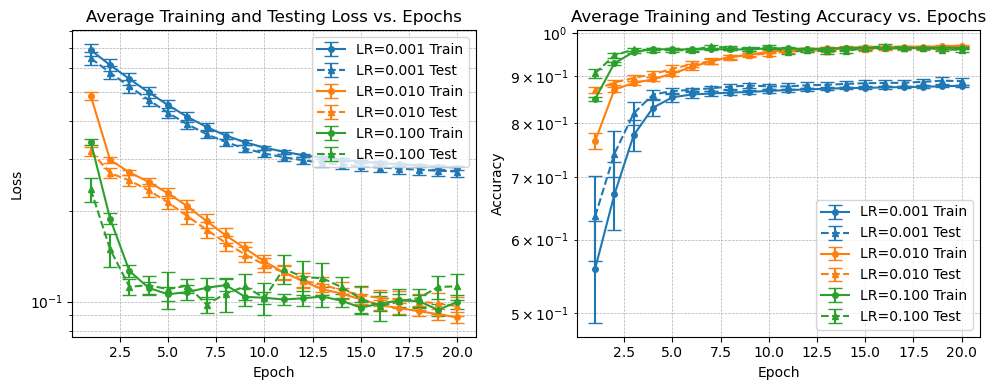

In [7]:
df = load_data("sqlite:///experiments.db")

if df.empty:
    print("No data found in the database.")

stats = compute_statistics(df)
plot_metrics(stats)

## Run 3
Add more trajectries to average over

In [8]:
n_trajectories = 100

parallel_experiments(
    learning_rates,
    n_trajectories,
    target_epochs,
    db_path=db_path,
    num_processes=num_processes  # Adjust based on your CPU cores
)

Resuming experiment: LR=0.001, Trajectory=0, Start Epoch=21
Resuming experiment: LR=0.001, Trajectory=1, Start Epoch=21
Resuming experiment: LR=0.001, Trajectory=2, Start Epoch=21
Resuming experiment: LR=0.001, Trajectory=3, Start Epoch=21
Resuming experiment: LR=0.001, Trajectory=4, Start Epoch=21
Resuming experiment: LR=0.001, Trajectory=5, Start Epoch=21
Resuming experiment: LR=0.001, Trajectory=6, Start Epoch=21
Resuming experiment: LR=0.001, Trajectory=7, Start Epoch=21
Resuming experiment: LR=0.001, Trajectory=8, Start Epoch=21
Resuming experiment: LR=0.001, Trajectory=9, Start Epoch=21
Starting new experiment: LR=0.001, Trajectory=10
[LR=0.001, Trajectory=10, Epoch=1/20] Train Loss: 0.6411, Train Acc: 0.5613, Test Loss: 0.6104, Test Acc: 0.7300
[LR=0.001, Trajectory=10, Epoch=2/20] Train Loss: 0.5776, Train Acc: 0.7775, Test Loss: 0.5423, Test Acc: 0.8500
[LR=0.001, Trajectory=10, Epoch=3/20] Train Loss: 0.5212, Train Acc: 0.8150, Test Loss: 0.4816, Test Acc: 0.8400
[LR=0.001, T

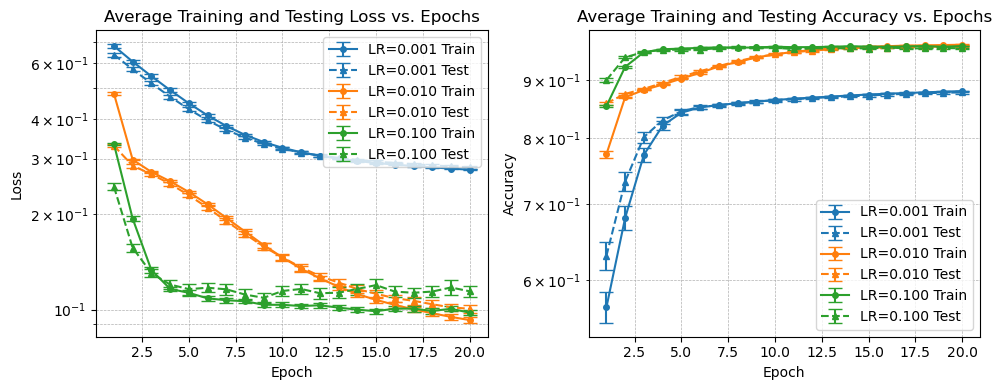

In [9]:
df = load_data("sqlite:///experiments.db")

if df.empty:
    print("No data found in the database.")

stats = compute_statistics(df)
plot_metrics(stats)